# Table of Contents
The 
* Effective Machine Learning
    * Disproportional Data sampling
    * EDA & Preprocessing
    * Model Selection and Evaluation
* Efficient Machine Learning 
    * Model performance on different scale of sampling data
    * Potential integration with IPS(Intrusion Prevention System)


# Effective Machine Learning
Below is a summary of the performance metrics for each model tested on the **validation** dataset:


In [1]:
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.cluster import KMeans

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from PIL import Image
import warnings
from tqdm import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
RANDOM_STATE = 42
# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns]:
    print(f"Using {lib.__name__} {lib.__version__}")

Using pandas 2.2.2
Using sklearn 1.2.2
Using seaborn 0.12.2


## Importing Data
Since the original dataset is extremely bias so a dispropotional sampling was applied.

In [2]:
# dataset used
# replace with Zach's df
df2 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_2classes.csv")
df8 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_8classes.csv")
df34 = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.001_dist_percent_34classes.csv")

## EDA & Preprocessing
**Summary Table of EDA Methods and Preprocessing**
Following table is a brief summary of common Exploratory Data Analysis (EDA) and corresponding Preprocessing methods. 

| EDA Method|Typical Preprocessing/Feature Engineering|Relevancy to current probelm|
|--|--|--|
|Data Cleaning|Handle missing values, duplicates, and outliers.|outlier is the challenge of the dataset, capping techniques are applied to |
|Univariate Analysis|Normalize/encode features, transform skewed data.|show skewness of the data and visualize with histogram, boxplot, drop column with limited info|
|Multivariate Analysis|Normalize, reduce multicollinearity, apply dimensionality reduction.|show Correlation table and reduce dimension with PCA/t-CNS|
|Target Variable Analysis|Balance classes, transform skewed distributions.|the label class is highly biased , espcially for (D)DOS. Dispropotional Sampling is used to balance class |
|Time Series Analysis|Interpolate missing data, extract date/time features, apply smoothing.|N/A, since the dataset is already engineered and temporal information has been compacted|



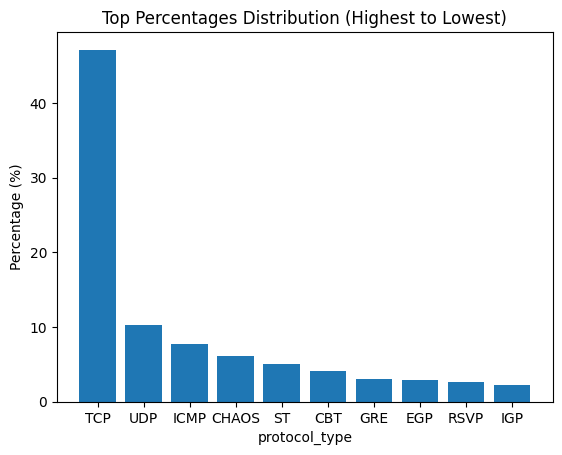

Top Percentages (from Highest to Lowest):
protocol_type
TCP                   47.130530
UDP                   10.242889
ICMP                   7.736383
CHAOS                  6.051682
ST                     5.001598
CBT                    4.070219
GRE                    2.958499
EGP                    2.919691
RSVP                   2.563576
IGP                    2.271378
BBN-RCC-MON            1.435876
XNET                   1.050084
PUP                    1.031822
NVP-II                 1.018125
ARGUS (deprecated)     0.856047
IDRP                   0.849199
HOPOPT                 0.652879
EMCON                  0.641465
IPv4                   0.470255
IPv6-Frag              0.264804
IGMP                   0.216865
IPv6-Route             0.152947
GGP                    0.125554
SDRP                   0.073049
IPv6                   0.036525
DDP                    0.029676
TP++                   0.025111
IL                     0.022828
IDPR-CMTP              0.020545
XTP             

In [3]:
# Calculate percentages for each unique value
value_counts = df2['protocol_type'].value_counts(normalize=True) * 100

# Sort percentages from highest to lowest
sorted_percentages = value_counts.sort_values(ascending=False)

# Get top 10 percentages (or fewer if there are less than unique values)
top_percentages = sorted_percentages.head(10)

# Plot histogram for the top values sorted by percentage
plt.bar(top_percentages.index, top_percentages.values)
plt.title("Top Percentages Distribution (Highest to Lowest)")
plt.xlabel("protocol_type")
plt.ylabel("Percentage (%)")
plt.xticks(top_percentages.index)  # Ensure x-axis labels show only top values
plt.show()

# Print the top sorted percentages
print("Top Percentages (from Highest to Lowest):")
print(sorted_percentages)

In [4]:
# Step 1: OneHotEncoding for categorical features
categorical_features = ['protocol_type']
categorical_transformer = OneHotEncoder(sparse_output=False)
encoded_categorical = categorical_transformer.fit_transform(df2[categorical_features])
# print(encoded_categorical)

# Create a DataFrame for the encoded categorical features
encoded_df = pd.DataFrame(encoded_categorical, columns=categorical_transformer.get_feature_names_out(categorical_features))

# Drop the original categorical columns and concatenate the encoded features
df2_filtered = df2.drop(categorical_features, axis=1)
df2_filtered = pd.concat([df2_filtered, encoded_df], axis=1)
df2_filtered.head()

,flow_duration,header_length,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,protocol_type_RSVP,protocol_type_SDRP,protocol_type_ST,protocol_type_TCP,protocol_type_TP++,protocol_type_TRUNK-1,protocol_type_TRUNK-2,protocol_type_UDP,protocol_type_XNET,protocol_type_XTP
0,1.828260,171,64.00,1,1,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.094752,60,65.91,2,2,0.0,False,True,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.775582,583305,63.60,101,101,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.488923,3754787,63.85,2722,2722,0.0,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.264529,132935,47.00,113,113,0.0,False,False,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


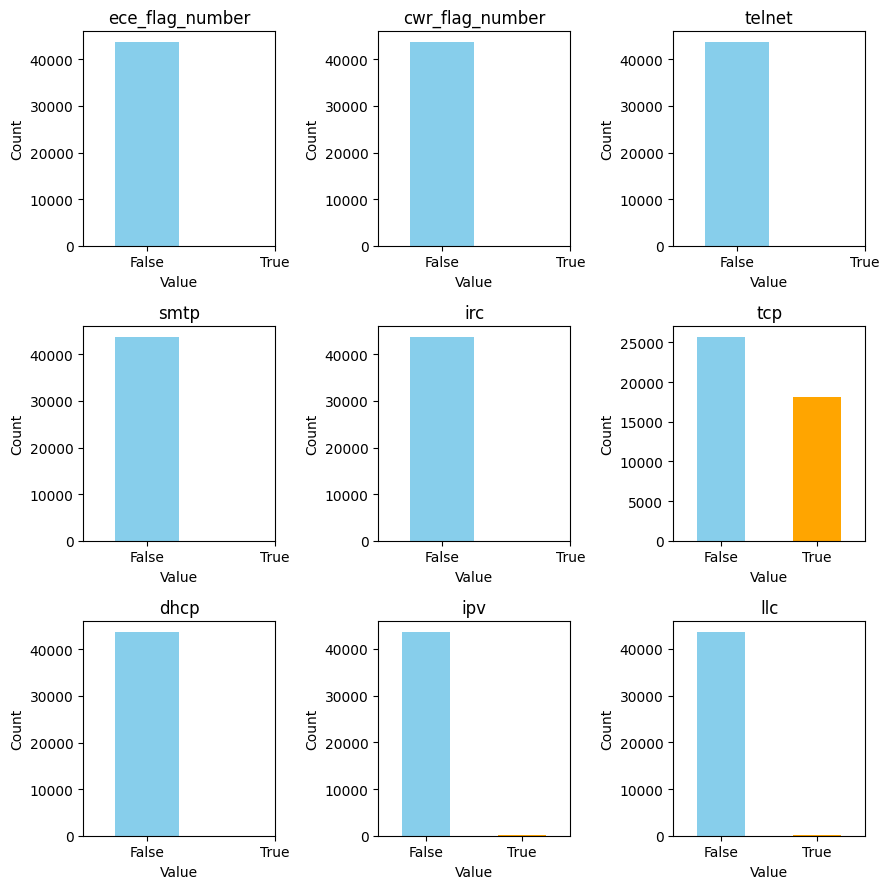

In [5]:
# filter out columns with uniform distribution(always the same value)
skewness = df2_filtered.skew()
# print(skewness)

df2_ls = df2_filtered.loc[:,skewness<0.00001]

# Create a grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(9, 9))  # 3 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each column's histogram in the corresponding subplot
for i, column in enumerate(df2_ls.columns):
    # Count the occurrences of True and False
    value_counts = df2_ls[column].value_counts()
    # Plot the histogram
    value_counts.plot(kind='bar', color=['skyblue', 'orange'], ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], rotation=0)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

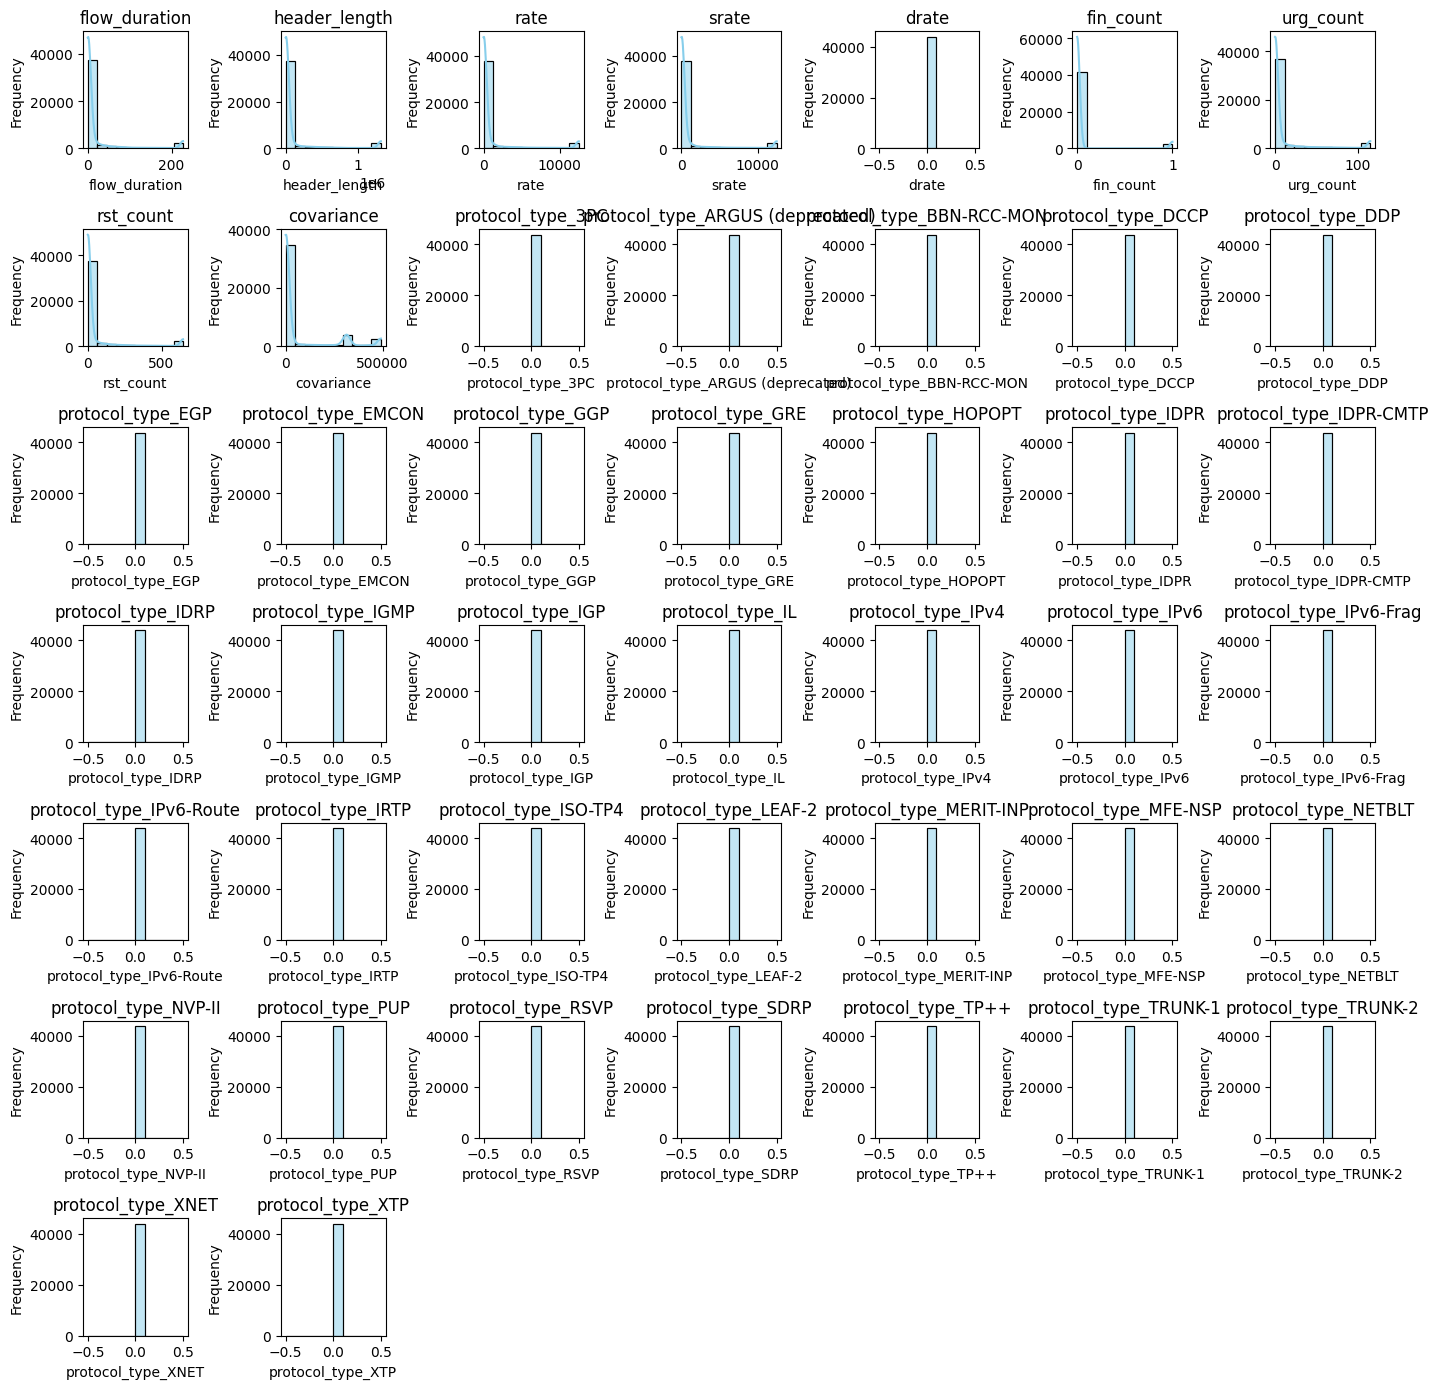

In [6]:
# analyze the colunmn with high abs skew values
df2_hs = df2_filtered.loc[:,abs(skewness)>5]

# print(df2_hs.head(10))

# # Identify continuous columns (e.g., numeric columns)
continuous_columns = df2_hs.select_dtypes(include=['float64', 'int64']).columns

# Set up the plotting
plt.figure(figsize=(14, 14))

# delete columns with too high skewness
from scipy.stats import mstats

df_winsorized = df2_hs[continuous_columns].apply(lambda x: mstats.winsorize(x, limits=[0.05, 0.05]))

# Loop through continuous columns and plot histograms
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(7,7, i)  
    sns.histplot(df_winsorized[col], kde=True, bins=10, color='skyblue', edgecolor='black')  # histogram with KDE
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
# Step 2: Variance threshold for low variance
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.01) #Removing both constant and quasi-constant
var_thr.fit(df2_filtered)

var_thr.get_support()
concol = [column for column in df2_filtered.columns 
          if column not in df2_filtered.columns[var_thr.get_support()]]
print(f'columns of low variance: {concol}')
df2_normal = df2_filtered.drop(concol,axis =1)
df2_normal.head()

columns of low variance: ['drate', 'ece_flag_number', 'cwr_flag_number', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'dhcp', 'arp', 'ipv', 'llc', 'protocol_type_3PC', 'protocol_type_ARGUS (deprecated)', 'protocol_type_DCCP', 'protocol_type_DDP', 'protocol_type_EMCON', 'protocol_type_GGP', 'protocol_type_HOPOPT', 'protocol_type_IDPR', 'protocol_type_IDPR-CMTP', 'protocol_type_IDRP', 'protocol_type_IGMP', 'protocol_type_IL', 'protocol_type_IPv4', 'protocol_type_IPv6', 'protocol_type_IPv6-Frag', 'protocol_type_IPv6-Route', 'protocol_type_IRTP', 'protocol_type_ISO-TP4', 'protocol_type_LEAF-2', 'protocol_type_MERIT-INP', 'protocol_type_MFE-NSP', 'protocol_type_NETBLT', 'protocol_type_SDRP', 'protocol_type_TP++', 'protocol_type_TRUNK-1', 'protocol_type_TRUNK-2', 'protocol_type_XTP']


,flow_duration,header_length,duration,rate,srate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,...,protocol_type_GRE,protocol_type_ICMP,protocol_type_IGP,protocol_type_NVP-II,protocol_type_PUP,protocol_type_RSVP,protocol_type_ST,protocol_type_TCP,protocol_type_UDP,protocol_type_XNET
0,1.828260,171,64.00,1,1,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.094752,60,65.91,2,2,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,13.775582,583305,63.60,101,101,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.488923,3754787,63.85,2722,2722,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.264529,132935,47.00,113,113,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


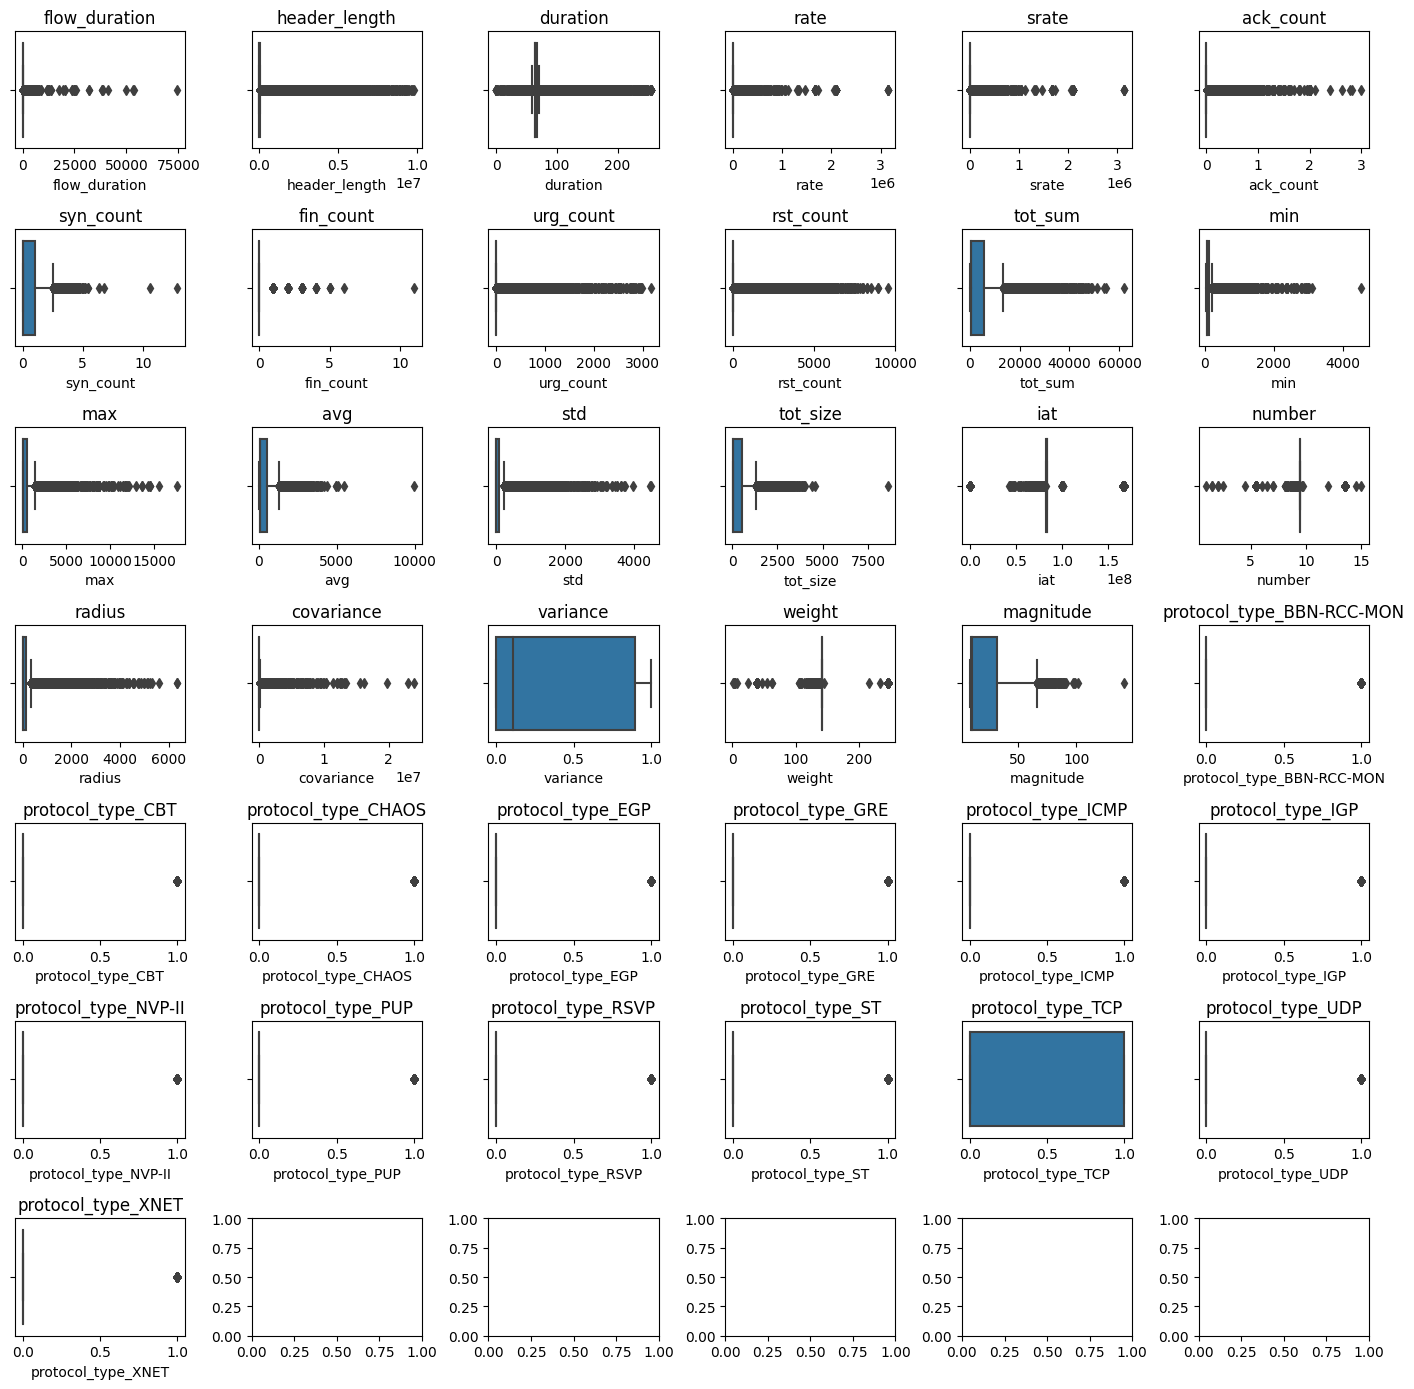

In [8]:
# show boxplot of parameter with comparatively normal distribution
continuous_columns = df2_normal.select_dtypes(include=['float64', 'int64']).columns

# Create a grid for the boxplots
fig, axes = plt.subplots(7, 6, figsize=(14, 14))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot the boxplot
for i, col in enumerate(continuous_columns):
    sns.boxplot(x=df2_normal[col], ax=axes[i])
    axes[i].set_title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

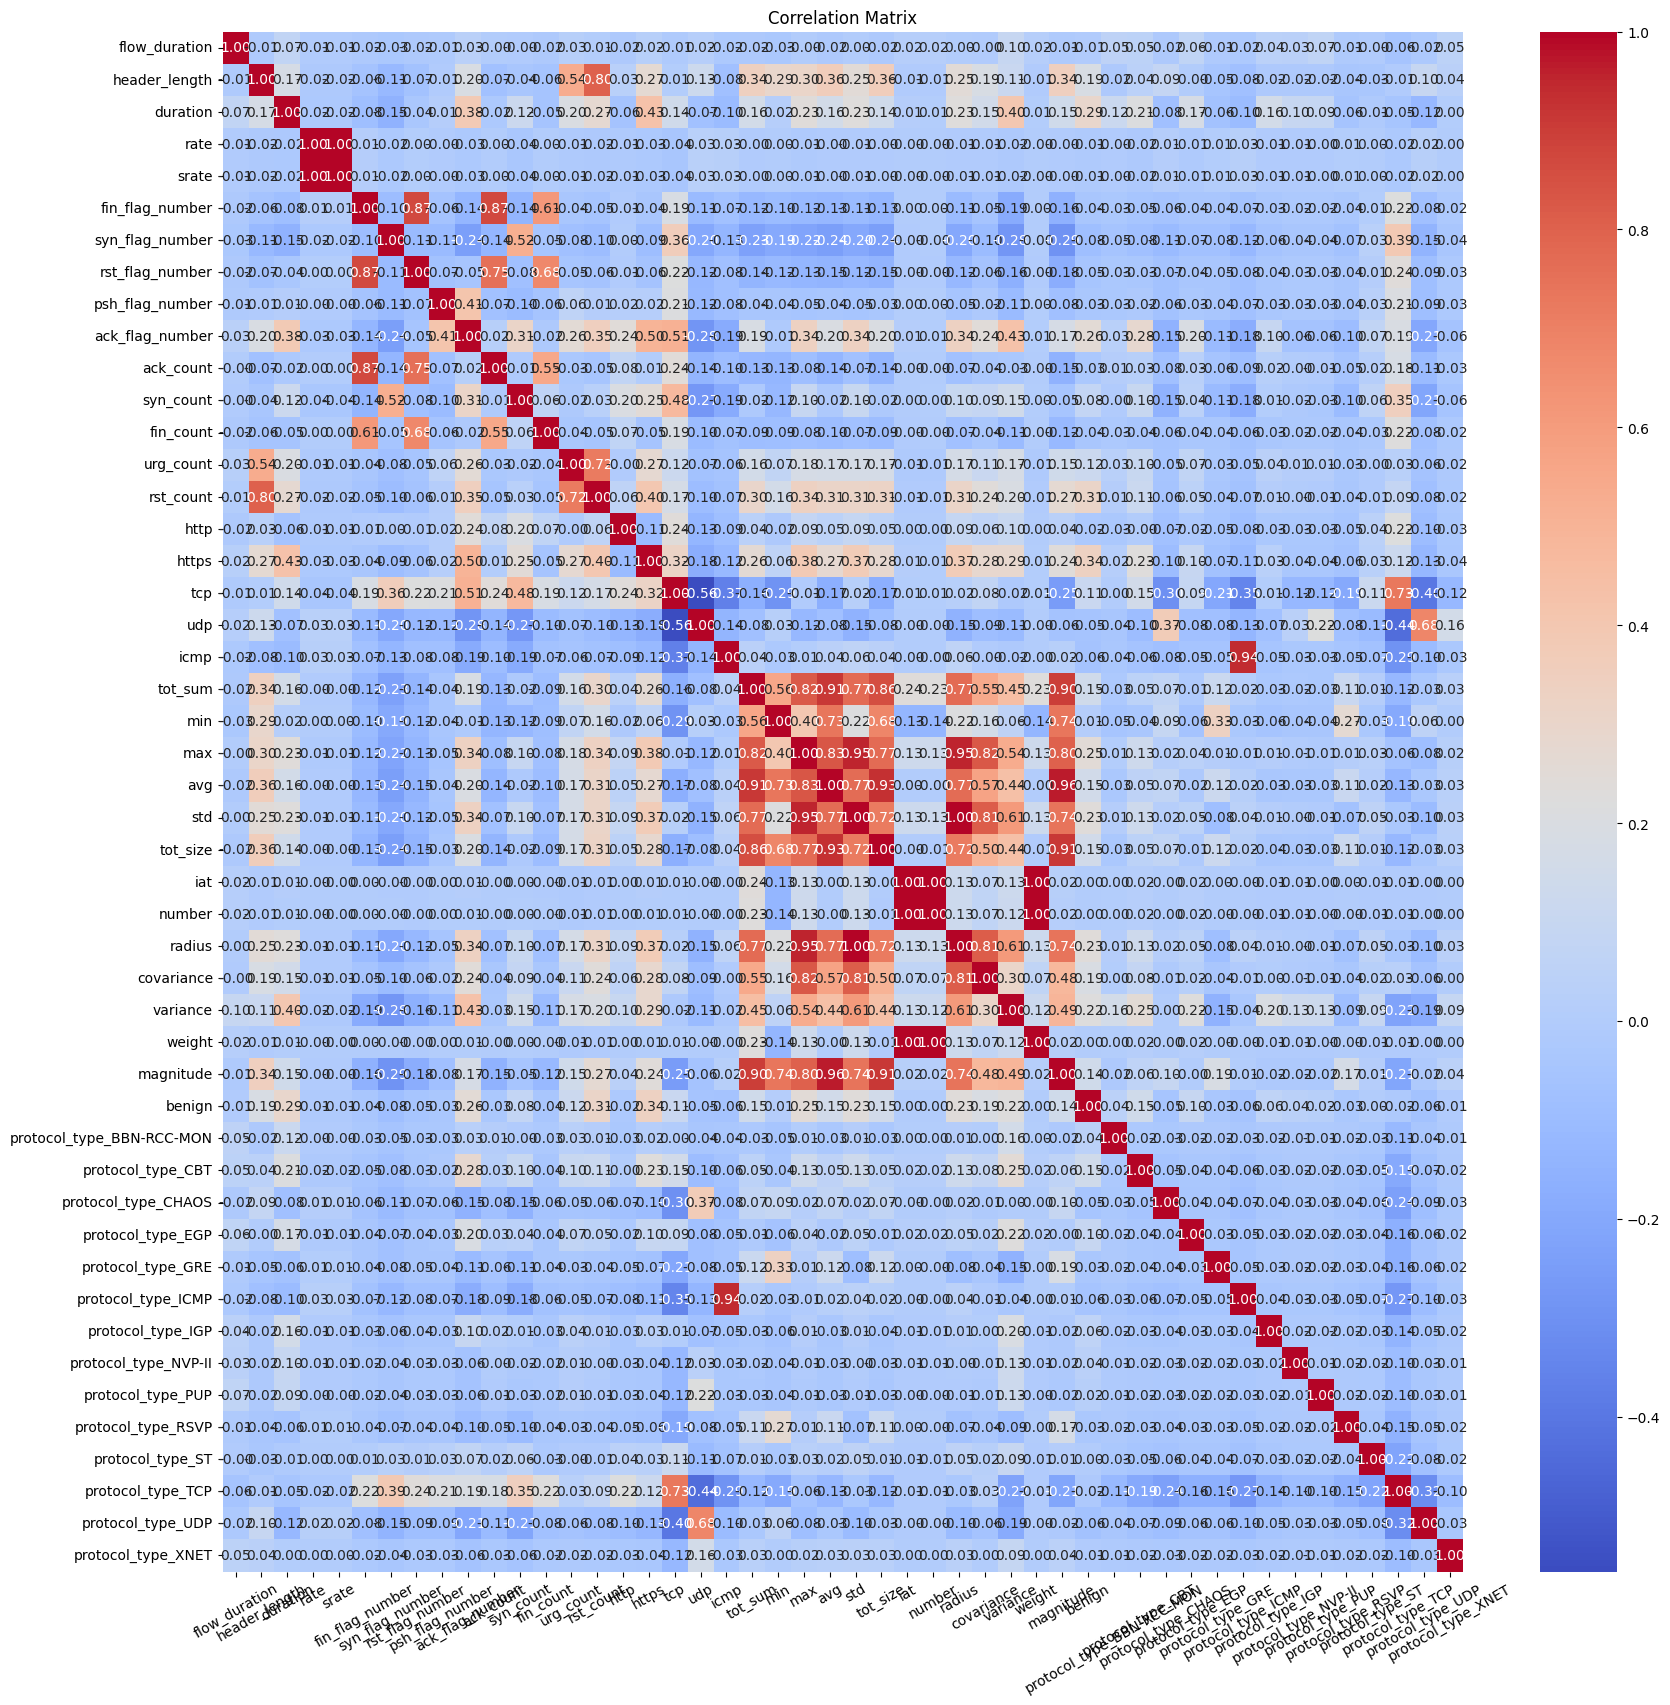

In [9]:
# Correlation Analysis
corr_matrix = df2_normal.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=30)
plt.title('Correlation Matrix')
plt.show()

In [10]:
# Step 3: Correlation filtering (custom function)
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.to_drop_ = None

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        
        # Compute the correlation matrix
        corr_matrix = X.corr().abs()
        
        # Identify highly correlated features
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.to_drop_ = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.threshold)]
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        X = pd.DataFrame(X)
        
        # Drop identified columns
        return X.drop(columns=self.to_drop_, errors='ignore')

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

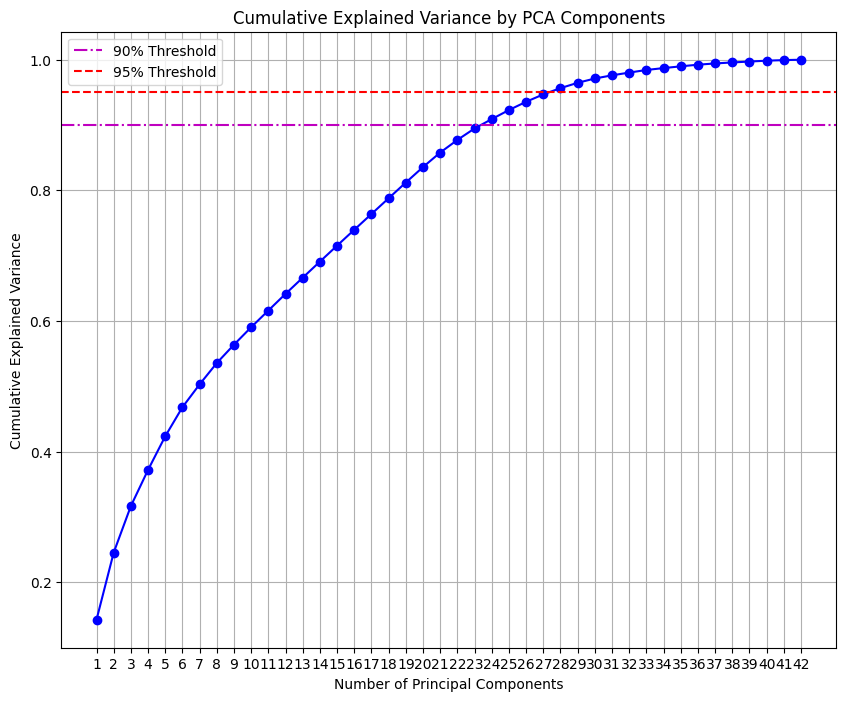

In [11]:
# Dimension Reduction Using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_reduced = CorrelationFilter(threshold=0.95).fit_transform(df2_normal)

# remove the label value
label=df2_normal["benign"]
df_reduced.drop("benign", axis=1)

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_reduced)

def CumuPlot(df):
    # Apply PCA with the adjusted number of components
    pca = PCA()
    
    df_pca = pca.fit_transform(df)
    
    # Calculate cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot cumulative explained variance
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.axhline(y=0.90, color='m', linestyle='-.', label='90% Threshold')  # Optional threshold line
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')  # Optional threshold line
    plt.xticks(range(1, len(cumulative_variance) + 1))  # Ensure x-ticks align with components
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.legend()
    plt.grid()
    plt.show()
    
CumuPlot(df_scaled)

In [12]:
# Apply PCA and retain the top n components
n_components = 26 #take 95% variance as target
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df_scaled)

# Convert NumPy array to DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Export to CSV
df_pca.to_csv('pca_transformed_data.csv', index=False)

## Models Selection & Evaluation
|Model|Type|Advantage|
|--|--|--|
|Logistic Regression|Supervised  |Easy to implement, computational efficient|
|KNN               |Supervised  |widely-used for classification of known number(k) of clusters, can upgrade to outlier robust variant: DBSCAN|
|Random Forest     |Supervised|Ensemble decision trees, robust to skewness of data|
|Auto-encoder      |Unsupervised|Deep Learning model for abnormal detection, which only differentiate benign and attack flow|


In [13]:
def split(df,label = "label"):
    
    # Sorting our dataset into features and target
    X = df.drop(label, axis = 1)
    y = df[label]
    
    # splitting out dataset to train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # scaling our features
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.fit_transform(X_test)
    
    return scaled_X_train, scaled_X_test, y_train, y_test

In [14]:
#df2_feat = df2_filtered.drop(tbd_ls_cols + tbd_hs_cols,axis =1)
df2_feat = pd.read_csv('/kaggle/working/pca_transformed_data.csv')
df2_feat['label']=label
scaled_X_train, scaled_X_test, y_train, y_test = split(df2_feat)

In [15]:
# creating dataframes to store result metrics
columns = ["Logistic Regression", "KNN", "Random Forest"]
index = ["Accuracy", "Recall", "Precision", "F1-Score"]

metrics_2 = pd.DataFrame(index=index, columns=columns)
metrics_8 = pd.DataFrame(index=index, columns=columns)
metrics_34 = pd.DataFrame(index=index, columns=columns)

In [16]:
# inserts the metrics of the model into the metrics dataframe
def insert_metrics(classes, model_name, metrics):
    if classes == 2:
        metrics_2.loc['Accuracy':'F1-Score', model_name] = metrics
    elif classes == 8:
        metrics_8.loc['Accuracy':'F1-Score', model_name] = metrics
    else:
        metrics_34.loc['Accuracy':'F1-Score', model_name] = metrics

In [17]:
# displays the Classification Report and Confusion Matrix
# inserts the metrics of the model into the metrics dataframe
def evaluate(model, X_test, y_test, target_names, classes, model_name):
    pred = model.predict(X_test)

    # print(pred[:5])
    # print(f'y_test.type:{type(y_test)}.shape:{y_test.shape} & y_test.type:{type(pred)}.shape:{pred.shape}')
    accuracy = accuracy_score(y_test, pred)
    recall = recall_score(y_test, pred, average='macro')
    precision = precision_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    insert_metrics(classes, model_name, [accuracy, recall, precision, f1])
    
    print(classification_report(y_test, pred, digits = 3))

    if classes == 2 or classes == 8:
        plt.figure(figsize = (4, 2), dpi = 300)
        ConfusionMatrixDisplay(np.round(confusion_matrix(y_test, pred, normalize="true"), 2), 
                               display_labels = target_names).plot()
        plt.title(model_name)
        plt.xticks(rotation=30);

In [18]:
!mkdir Models
def pickle_save(model, name):
    model_filename = 'Models/' + name + '.pkl'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)

    print(f"Model saved to {name}")

def pickle_load(name):
    model_filename = 'Models/' + name + '.pkl'
    try:
        with open(model_filename, 'rb') as model_file:
            model = pickle.load(model_file)
        print(f"Model loaded from {model_filename}")
        return model
    except FileNotFoundError:
        print(f"Error: The file '{model_filename}' does not exist.")
        return None
    except pickle.UnpicklingError:
        print(f"Error: Failed to load the model from '{model_filename}'. The file might be corrupted.")
        return None

In [19]:
# essential for df2
target_names = ["Attack", "Benign"]

              precision    recall  f1-score   support

       False      1.000     1.000     1.000      8435
        True      1.000     1.000     1.000       327

    accuracy                          1.000      8762
   macro avg      1.000     1.000     1.000      8762
weighted avg      1.000     1.000     1.000      8762

Model saved to logreg_2


<Figure size 1200x600 with 0 Axes>

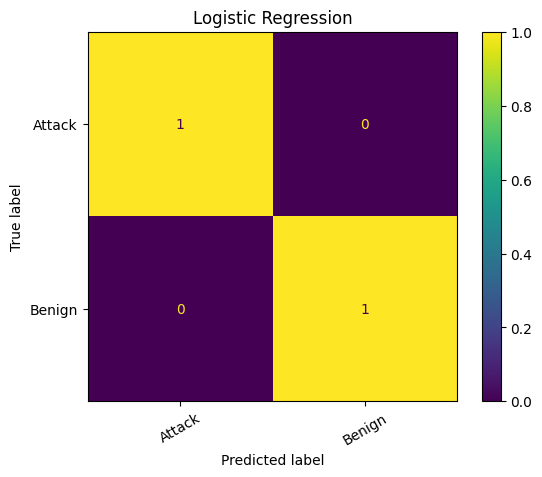

In [20]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 2, "Logistic Regression")
pickle_save(logreg_model, "logreg_2")

              precision    recall  f1-score   support

       False      1.000     1.000     1.000      8435
        True      1.000     0.991     0.995       327

    accuracy                          1.000      8762
   macro avg      1.000     0.995     0.998      8762
weighted avg      1.000     1.000     1.000      8762

Model saved to knn_2


<Figure size 1200x600 with 0 Axes>

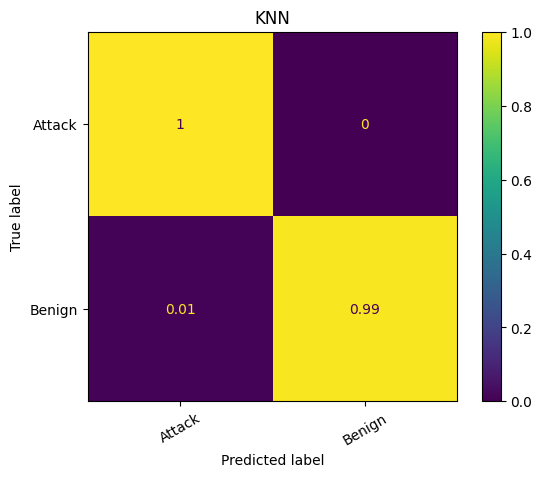

In [21]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 2, "KNN")
pickle_save(knn, "knn_2")

              precision    recall  f1-score   support

       False      1.000     1.000     1.000      8435
        True      1.000     0.988     0.994       327

    accuracy                          1.000      8762
   macro avg      1.000     0.994     0.997      8762
weighted avg      1.000     1.000     1.000      8762

Model saved to rfc_2


<Figure size 1200x600 with 0 Axes>

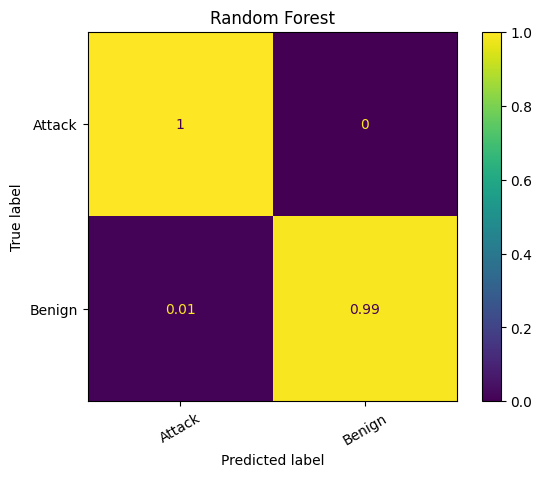

In [22]:
# Weight-balanced
# rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 2, "Random Forest")
pickle_save(rfc, "rfc_2")

In [23]:
# exporting and displaying the class 2 metrics
metrics_2.to_csv('metrics_2.csv', index=True)
metrics_2

,Logistic Regression,KNN,Random Forest
Accuracy,1.0,0.999658,0.999543
Recall,1.0,0.995413,0.993884
Precision,1.0,0.999822,0.999763
F1-Score,1.0,0.997607,0.996805


### 8 Classes

In [24]:
# df8_filtered = df8.drop(default_drop_col,axis=1)
# df8_normal = df8_filtered.drop(tbd_ls_cols + tbd_hs_cols,axis =1)
df8_feat = pd.read_csv('/kaggle/working/pca_transformed_data.csv')
df8_feat['label']=df8['label']
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]
scaled_X_train, scaled_X_test, y_train, y_test = split(df8_feat)

              precision    recall  f1-score   support

      Benign      1.000     1.000     1.000       327
  BruteForce      0.100     0.008     0.015       122
        DDoS      0.732     0.913     0.812      4150
         DoS      0.484     0.191     0.274      1361
       Mirai      0.981     0.989     0.985       938
       Recon      0.484     0.598     0.535       835
    Spoofing      0.614     0.463     0.528       471
         Web      0.470     0.321     0.381       558

    accuracy                          0.708      8762
   macro avg      0.608     0.560     0.566      8762
weighted avg      0.675     0.708     0.674      8762

Model saved to logreg_8


<Figure size 1200x600 with 0 Axes>

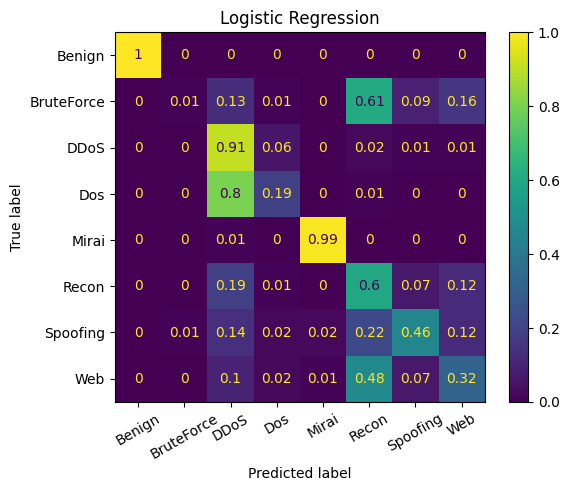

In [25]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 8, "Logistic Regression")
pickle_save(logreg_model, "logreg_8")

              precision    recall  f1-score   support

      Benign      0.997     0.997     0.997       327
  BruteForce      0.267     0.164     0.203       122
        DDoS      0.870     0.868     0.869      4150
         DoS      0.616     0.616     0.616      1361
       Mirai      0.996     0.990     0.993       938
       Recon      0.632     0.723     0.674       835
    Spoofing      0.678     0.567     0.617       471
         Web      0.541     0.556     0.548       558

    accuracy                          0.787      8762
   macro avg      0.700     0.685     0.690      8762
weighted avg      0.786     0.787     0.786      8762

Model saved to knn_8


<Figure size 1200x600 with 0 Axes>

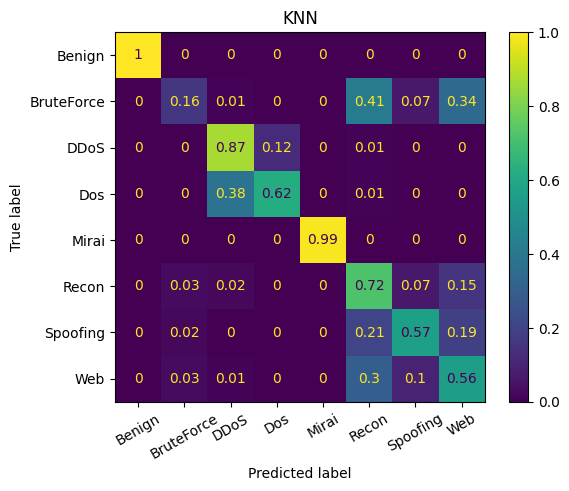

In [26]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 8, "KNN")
pickle_save(knn, "knn_8")

              precision    recall  f1-score   support

      Benign      1.000     0.997     0.998       327
  BruteForce      0.500     0.131     0.208       122
        DDoS      0.850     0.888     0.869      4150
         DoS      0.620     0.522     0.566      1361
       Mirai      0.999     0.995     0.997       938
       Recon      0.635     0.768     0.695       835
    Spoofing      0.684     0.603     0.641       471
         Web      0.583     0.590     0.586       558

    accuracy                          0.790      8762
   macro avg      0.734     0.687     0.695      8762
weighted avg      0.784     0.790     0.784      8762

Model saved to rfc_8


<Figure size 1200x600 with 0 Axes>

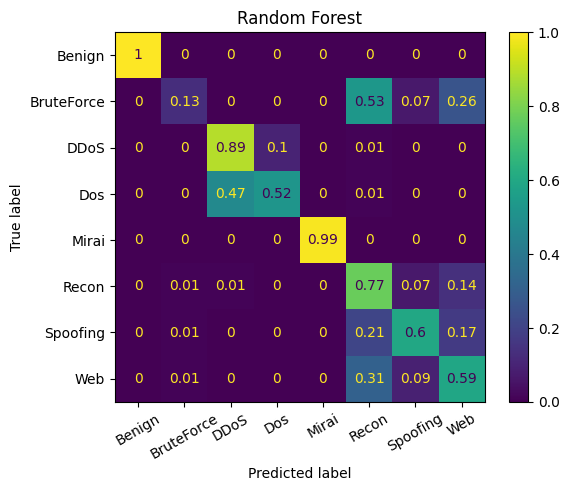

In [27]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 8, "Random Forest")
pickle_save(rfc, "rfc_8")

In [28]:
# exporting and displaying the class 8 metrics
metrics_8.to_csv('metrics_8.csv', index=True)
metrics_8

,Logistic Regression,KNN,Random Forest
Accuracy,0.707601,0.787377,0.790231
Recall,0.560323,0.685245,0.686579
Precision,0.608169,0.69952,0.733857
F1-Score,0.566355,0.689835,0.695056


### 34 Classes

In [29]:
df34_feat = pd.read_csv('/kaggle/working/pca_transformed_data.csv')
df34_feat['label']=df34['label']
scaled_X_train, scaled_X_test, y_train, y_test = split(df34_feat)
print(y_test.value_counts())
target_names = list(y_test.unique())

label
DDoS-ICMP_Flood            484
DDoS-UDP_Flood             456
DDoS-TCP_Flood             438
DDoS-RSTFINFlood           432
DDoS-SYN_Flood             432
DDoS-PSHACK_Flood          432
DDoS-SynonymousIP_Flood    418
DoS-UDP_Flood              412
DoS-TCP_Flood              395
DoS-SYN_Flood              371
BenignTraffic              328
Mirai-greeth_flood         322
Mirai-udpplain             313
Mirai-greip_flood          303
DDoS-ICMP_Fragmentation    272
MITM-ArpSpoofing           248
DDoS-ACK_Fragmentation     246
DDoS-UDP_Fragmentation     246
DNS_Spoofing               223
Recon-HostDiscovery        207
Recon-OSScan               198
Recon-PortScan             189
DoS-HTTP_Flood             182
VulnerabilityScan          160
DDoS-HTTP_Flood            151
DDoS-SlowLoris             143
DictionaryBruteForce       122
BrowserHijacking           104
CommandInjection           101
SqlInjection               100
XSS                         91
Backdoor_Malware            86
Re

In [30]:
logreg_model = LogisticRegression(C = 1, max_iter=500, solver='lbfgs', penalty='l2', random_state=42)
logreg_model.fit(scaled_X_train, y_train)

evaluate(logreg_model, scaled_X_test, y_test, target_names, 34, "Logistic Regression")
pickle_save(logreg_model, "logreg_34")

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                         precision    recall  f1-score   support

       Backdoor_Malware      0.161     0.058     0.085        86
          BenignTraffic      1.000     1.000     1.000       328
       BrowserHijacking      0.222     0.058     0.092       104
       CommandInjection      0.650     0.129     0.215       101
 DDoS-ACK_Fragmentation      0.900     0.955     0.927       246
        DDoS-HTTP_Flood      0.643     0.728     0.683       151
        DDoS-ICMP_Flood      0.998     1.000     0.999       484
DDoS-ICMP_Fragmentation      0.996     0.982     0.989       272
      DDoS-PSHACK_Flood      1.000     0.998     0.999       432
       DDoS-RSTFINFlood      0.998     1.000     0.999       432
         DDoS-SYN_Flood      0.549     0.954     0.697       432
         DDoS-SlowLoris      0.347     0.427     0.382       143
DDoS-SynonymousIP_Flood      0.637     0.639     0.638       418
         DDoS-TCP_Flood      0.545     0.913     0.683       438
         DDoS-UDP_Flood 

In [31]:
knn = KNeighborsClassifier(n_neighbors = 34)
knn.fit(scaled_X_train, y_train)

evaluate(knn, scaled_X_test, y_test, target_names, 34, "KNN")
pickle_save(knn, "knn_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.143     0.105     0.121        86
          BenignTraffic      0.985     0.991     0.988       328
       BrowserHijacking      0.242     0.221     0.231       104
       CommandInjection      0.299     0.228     0.258       101
 DDoS-ACK_Fragmentation      0.967     0.947     0.957       246
        DDoS-HTTP_Flood      0.640     0.728     0.681       151
        DDoS-ICMP_Flood      0.984     0.998     0.991       484
DDoS-ICMP_Fragmentation      0.993     0.982     0.987       272
      DDoS-PSHACK_Flood      0.958     0.993     0.975       432
       DDoS-RSTFINFlood      0.998     0.998     0.998       432
         DDoS-SYN_Flood      0.790     0.792     0.791       432
         DDoS-SlowLoris      0.700     0.685     0.693       143
DDoS-SynonymousIP_Flood      0.744     0.825     0.782       418
         DDoS-TCP_Flood      0.638     0.833     0.723       438
         DDoS-UDP_Flood 

In [32]:
rfc = RandomForestClassifier(n_estimators=100, class_weight="balanced")
rfc.fit(scaled_X_train, y_train)

evaluate(rfc, scaled_X_test, y_test, target_names, 34, "Random Forest")
pickle_save(rfc, "rfc_34")

                         precision    recall  f1-score   support

       Backdoor_Malware      0.237     0.221     0.229        86
          BenignTraffic      0.997     0.997     0.997       328
       BrowserHijacking      0.250     0.221     0.235       104
       CommandInjection      0.297     0.267     0.281       101
 DDoS-ACK_Fragmentation      0.988     0.988     0.988       246
        DDoS-HTTP_Flood      0.781     0.755     0.768       151
        DDoS-ICMP_Flood      1.000     1.000     1.000       484
DDoS-ICMP_Fragmentation      0.996     0.985     0.991       272
      DDoS-PSHACK_Flood      1.000     0.998     0.999       432
       DDoS-RSTFINFlood      1.000     1.000     1.000       432
         DDoS-SYN_Flood      0.599     0.903     0.720       432
         DDoS-SlowLoris      0.833     0.839     0.836       143
DDoS-SynonymousIP_Flood      0.695     0.732     0.713       418
         DDoS-TCP_Flood      0.530     0.301     0.384       438
         DDoS-UDP_Flood 

In [33]:
# exporting and displaying the class 34 metrics
metrics_34.to_csv('metrics_34.csv', index=True)
metrics_34

,Logistic Regression,KNN,Random Forest
Accuracy,0.656814,0.718101,0.707715
Recall,0.538428,0.600148,0.622807
Precision,0.545478,0.605039,0.63189
F1-Score,0.515507,0.598646,0.616807


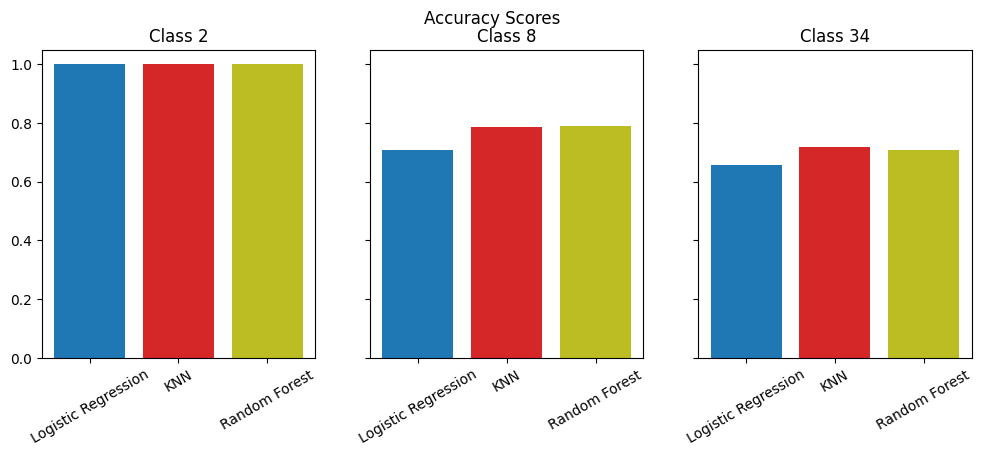

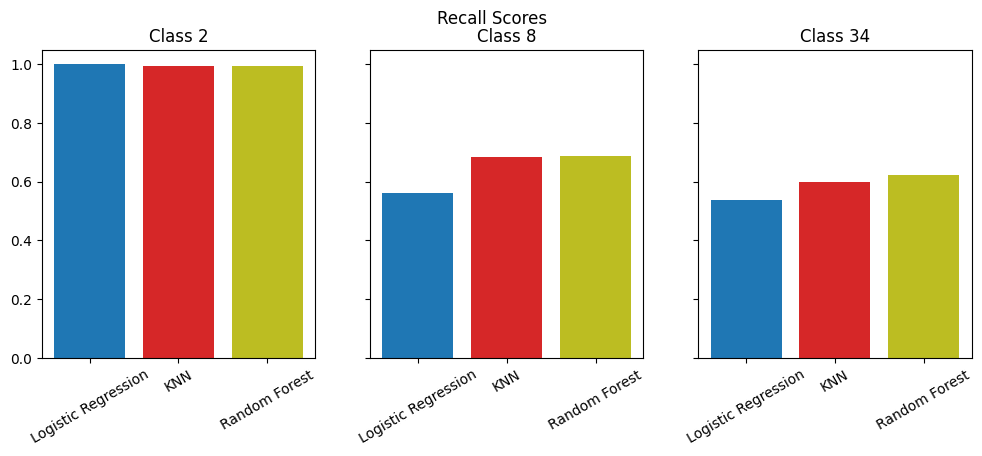

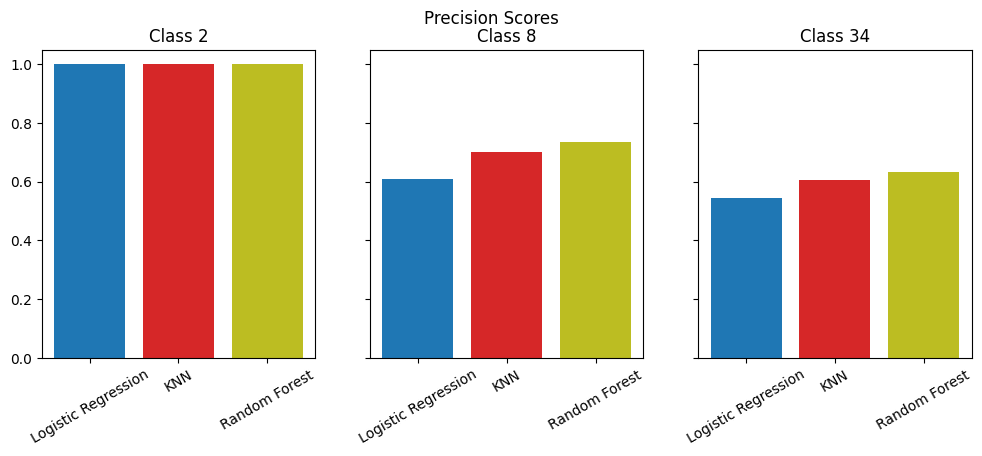

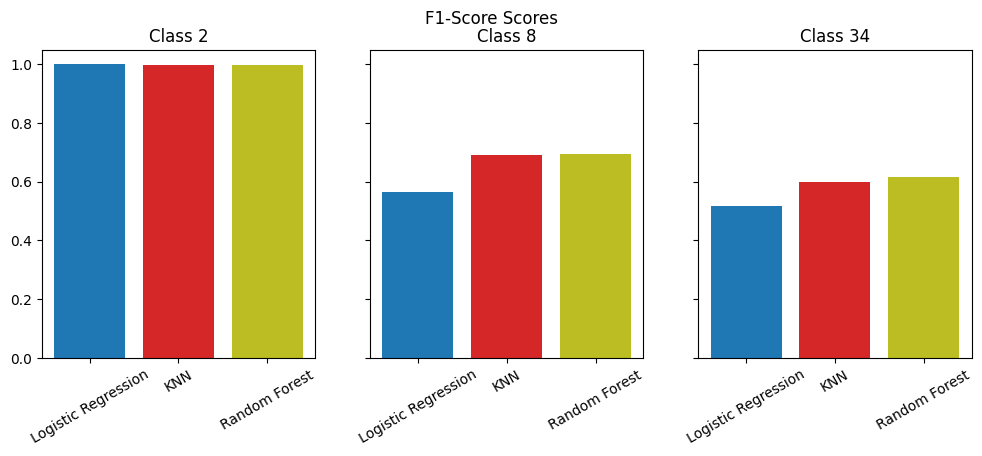

In [34]:
# List of model names
model_names = ["Logistic Regression", "KNN", "Random Forest"]

# List of dataframes
dataframes = [metrics_2, metrics_8, metrics_34]

# List of classes
classes = [2, 8, 34]

# List of metric names
metrics = ["Accuracy", "Recall", "Precision", "F1-Score"]

# Create a color mapping dictionary for each model
model_colors = {
    "Logistic Regression": 'tab:blue',
    "KNN": 'tab:red',
    "Random Forest": 'tab:olive',
}

# Creating subplots for each metric
for metric in metrics:
    fig, axs = plt.subplots(1, len(classes), figsize=(12, 4), sharey=True)
    fig.suptitle(f"{metric} Scores")

    for i, df in enumerate(dataframes):
        axs[i].set_title(f"Class {classes[i]}")
        
        # Plotting the respective metric score for each model with specified color
        for model_name in model_names:
            color = model_colors[model_name]
            axs[i].bar(model_name, df.loc[metric, model_name], color=color)
        
        # Set x-axis ticks and labels, rotating labels by 90 degrees
        axs[i].set_xticks(range(len(model_names)))
        axs[i].set_xticklabels(model_names, rotation=30)
    
    # Save the figure
    plt.savefig(f'{metric}_scores.png', bbox_inches='tight')
    
    plt.show()

# Efficient Intrution Detection
In real-world application, efficiency is important

## Evaluation of Models Trained on Smaller Data Subsets Applied to Larger Datasets

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Preprocessing for numeric and categorical features
label_cols = ["benign","label"]
skip_cols = categorical_features + label_cols
pass_cols = [col for col in df2.columns if col not in skip_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", "passthrough", pass_cols),
    ]
)

# Create the pipeline 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler()),
    ("variance_filter", var_thr),
    ("correlation_filter", CorrelationFilter(threshold=0.9)),
    ("pca", pca)
])

Model loaded from Models/rfc_8.pkl


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

              precision    recall  f1-score   support

      Benign      0.100     0.016     0.027      1704
  BruteForce      0.000     0.000     0.000       691
        DDoS      0.575     0.858     0.689     21541
         DoS      0.238     0.005     0.010      7079
       Mirai      0.542     0.536     0.539      4881
       Recon      0.327     0.316     0.322      4455
    Spoofing      0.310     0.257     0.281      2498
         Web      0.300     0.209     0.246      3030

    accuracy                          0.520     45879
   macro avg      0.299     0.275     0.264     45879
weighted avg      0.437     0.520     0.446     45879

Model loaded from Models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.058     0.004     0.007      1704
  BruteForce      0.023     0.003     0.005       691
        DDoS      0.329     0.217     0.261     21541
         DoS      0.295     0.576     0.390      7079
       Mirai      0.425     0.592     0.495

<Figure size 1200x600 with 0 Axes>

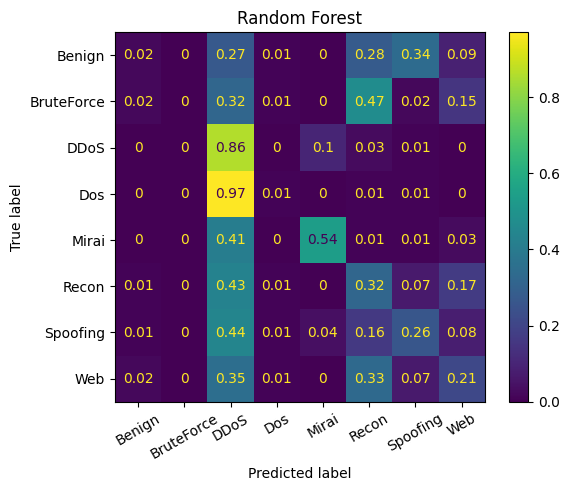

<Figure size 1200x600 with 0 Axes>

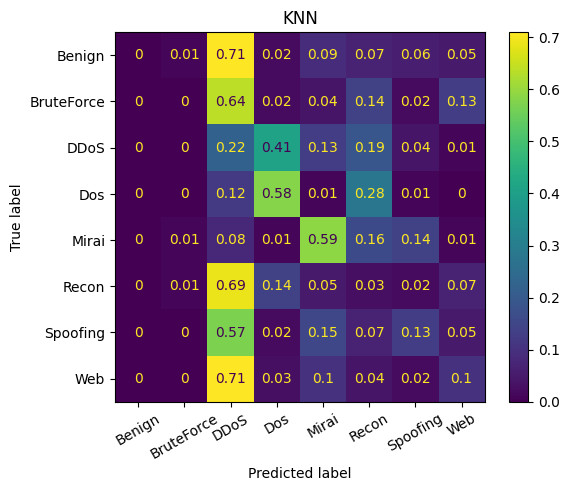

In [36]:
# test model on larger percentage
# df2_s = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.005_dist_percent_2classes.csv")
df8_s = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.005_dist_percent_8classes.csv")
# df34_s = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.005_dist_percent_34classes.csv")

# remove the label value
# label2=df2_s["benign"]
# df2_s.drop(["benign"],axis=1)
label8 = df8_s["label"]
# label34 = df34_s["label"]

# Convert NumPy array to DataFrame
df_processed = pipeline.fit_transform(df8_s)
df_s = pd.DataFrame(df_processed)

df_s['label'] = label8
scaled_X_train, scaled_X_test, y_train, y_test = split(df_s)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

Model loaded from Models/rfc_8.pkl
              precision    recall  f1-score   support

      Benign      0.044     0.013     0.020      3425
  BruteForce      0.000     0.000     0.000      1401
        DDoS      0.598     0.766     0.672     43287
         DoS      0.699     0.024     0.047     14227
       Mirai      0.641     0.767     0.698      9813
       Recon      0.348     0.385     0.366      8568
    Spoofing      0.322     0.317     0.319      5029
         Web      0.116     0.179     0.141      4866

    accuracy                          0.517     90616
   macro avg      0.346     0.306     0.283     90616
weighted avg      0.524     0.517     0.465     90616

Model loaded from Models/knn_8.pkl
              precision    recall  f1-score   support

      Benign      0.075     0.001     0.002      3425
  BruteForce      0.054     0.002     0.004      1401
        DDoS      0.493     0.376     0.427     43287
         DoS      0.355     0.553     0.433     14227
       M

<Figure size 1200x600 with 0 Axes>

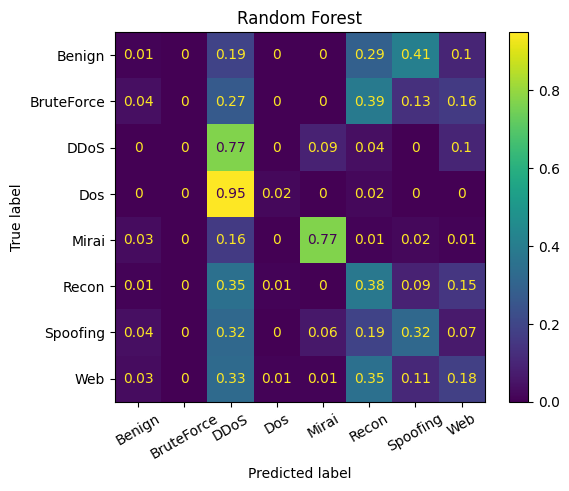

<Figure size 1200x600 with 0 Axes>

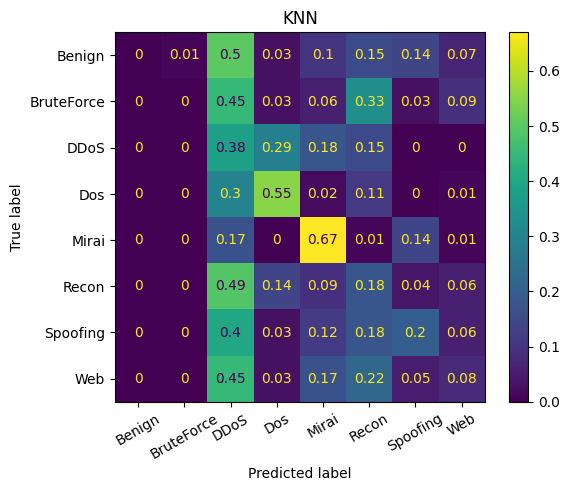

In [37]:
# test model on larger percentage
# df2_s = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.005_dist_percent_2classes.csv")
df8_m = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.01_dist_percent_8classes.csv")
# df34_s = pd.read_csv("/kaggle/input/disproportionate-sampling-dataset-for-ciciot2023/0.005_dist_percent_34classes.csv")

# remove the label value
# label2=df2_s["benign"]
# df2_s.drop(["benign"],axis=1)
label8 = df8_m["label"]
# label34 = df34_s["label"]

# Convert NumPy array to DataFrame
df_processed = pipeline.fit_transform(df8_m)
df_m = pd.DataFrame(df_processed)

df_m['label'] = label8
scaled_X_train, scaled_X_test, y_train, y_test = split(df_m)
target_names = ["Benign", "BruteForce", "DDoS", "Dos", "Mirai", "Recon", "Spoofing", "Web"]

rfc8_load = pickle_load("rfc_8")
evaluate(rfc8_load, scaled_X_test , y_test, target_names, 8, "Random Forest")

knn8_load = pickle_load("knn_8")
evaluate(knn8_load, scaled_X_test , y_test, target_names, 8, "KNN")

### Autoencoder

See: "Quantized Autoencoders (QAE)/Final Versions/QAE.py"

In [38]:
!pip install tensorflow_model_optimization

import optuna

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
import tensorflow_model_optimization as tfmot
import matplotlib.pyplot as plt
import numpy as np
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

# for lib in [pd, sk, sns, sv, optuna, tf, keras]:
for lib in [pd, sk, sns]:
    print(f"Using {lib.__name__} {lib.__version__}")

RANDOM_SEED = 5
PATH_TO_QAE_CLASS = "../../Quantized Autoencoders (QAE)/Final Versions"
tf.random.set_seed(RANDOM_SEED)
"""
# Import the QAE class
sys.path.append(os.path.abspath(PATH_TO_QAE_CLASS))
from QAE import QAE
print("INFO: QAE class successfully imported.")
"""

class QAE:
    """
    Creates a Quantized Autoencoder (QAE) for anomaly detection from a dataset composed of X_preprocessed and y.
    Note that the "y" series has no importance on its own: we only use it to make the train-test split,
    but in principle all your values in y should have the same label as you want anomaly detection,
    not classification.

    Last modification on the 8th of August 2024 by Alexandre Le Mercier.
    """
    def __init__(self, X_preprocessed, y, random_seed=5, test_size:float=0.3, first_layer:int=128,
                 verbose:bool=True, activation:str='relu', loss:str='mean_squared_error', optimizer:str='adam',
                 epochs:int=50, batch_size:int=32, shuffle:bool=True, figures_path:str="", name:str="autoencoder",
                 pruning_initial_sparsity:float=0.2, pruning_final_sparsity:float=0.8, pruning_begin_step:int=0,
                 pruning_end_step_divider:int=32*10, pruning_epochs:int=10, pruning_batch_size:int=32,
                 number_of_clusters:int=8, models_path:str="", cluster_epochs:int=10, cluster_batch_size:int=32,
                 use_regularization:bool=True, regularization_weights:float=0.001,threshold:float=None):

        self.F1_score = None
        self.recall = None
        self.precision = None
        self.accuracy = None
        self.confusion_matrix = None
        self.model_for_export = None
        self.history = None
        self.y_val = None
        self.y_train = None
        self.X_val = None
        self.X_train = None
        self.input_dim = None
        self.autoencoder = None
        self.pruning_end_step = None

        self.X_preprocessed = X_preprocessed
        self.y = y
        self.seed = random_seed
        self.test_size = test_size
        self.first_layer = first_layer
        self.verbose = verbose
        self.activation = activation
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.figures_path = figures_path
        self.name = name
        self.pruning_initial_sparsity = pruning_initial_sparsity
        self.pruning_final_sparsity = pruning_final_sparsity
        self.pruning_begin_step = pruning_begin_step
        self.pruning_end_step_divider = pruning_end_step_divider
        self.pruning_epochs = pruning_epochs
        self.pruning_batch_size = pruning_batch_size
        self.number_of_clusters = number_of_clusters
        self.models_path = models_path
        self.cluster_epochs = cluster_epochs
        self.cluster_batch_size = cluster_batch_size
        self.use_regularization = use_regularization
        self.regularization_weights = regularization_weights
        self.threshold = threshold

        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)

        #assert tf.__version__ == "2.13.0", 'TensorFlow 2.13 required for compatibility with tfmot 0.8.0.'
        assert self.first_layer % 8 == 0, 'The specified layer number is not dividable by 8.'

        self.verbose_message(f"QAE INFO: Bottleneck layer will be made of {self.first_layer//8} neurons.")

        self.split_data()
        self.create_autoencoder_model()
        self.compile_autoencoder()

        self.verbose_message("QAE model successfully created. Execute self.train_autoencoder() when ready.")

    def split_data(self):
        self.X_train, self.X_val, _, _ = train_test_split(self.X_preprocessed,
                                                          self.y, test_size=self.test_size,
                                                          random_state=self.seed)
        self.input_dim = self.X_train.shape[1]
        self.pruning_end_step =  len(self.X_train) // self.pruning_end_step_divider

    def create_autoencoder_model(self):
        # Function to optionally add regularizer
        def add_dense_layer(units):
            return layers.Dense(units, activation=self.activation,
                                kernel_regularizer=regularizers.l2(self.regularization_weights) if self.use_regularization else None)

        layers_list = [
            add_dense_layer(self.first_layer),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 8),
            add_dense_layer(self.first_layer // 4),
            add_dense_layer(self.first_layer // 2),
            add_dense_layer(self.first_layer),
            layers.Dense(self.input_dim, activation='sigmoid')
        ]

        self.autoencoder = Sequential(layers_list)
        self.autoencoder.build(input_shape=(None, self.input_dim))

    def compile_autoencoder(self):
        self.autoencoder.compile(optimizer=self.optimizer, loss=self.loss)
        if self.verbose:
            self.autoencoder.summary()

    def train_autoencoder(self):
        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                                            epochs=self.epochs,
                                            batch_size=self.batch_size,
                                            shuffle=self.shuffle,
                                            verbose=self.verbose,
                                            validation_data=(self.X_val, self.X_val))
        if self.verbose:
            self.plot_learning_curves()
        self.save_model(self.autoencoder, f"{self.name}_model")
        self.model_for_export = self.autoencoder
        self.verbose_message("QAE model successfully trained. Execute self.quantize_autoencoder()"
                             " or self.prune_and_cluster_autoencoder() when ready.")

    def plot_learning_curves(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Learning Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.figures_path + "QAE_learning_curves.png")
        plt.show()


    def representative_data_gen(self):
        for input_value in tf.data.Dataset.from_tensor_slices(self.X_train).batch(1).take(100):
            yield [tf.cast(input_value, tf.float32)]

    def quantize_parameters_and_activation_functions(self, model, name=None):
        if name is None:
            name = f"{self.name}_int_quant_model"
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = self.representative_data_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_int_quant_model = converter.convert()
        self.save_model(tflite_int_quant_model, name, '.tflite')

    def quantize_autoencoder(self):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.autoencoder)
        tflite_model = converter.convert()
        self.save_model(tflite_model, f'{self.name}_model', '.tflite')
        self.quantize_parameters_and_activation_functions(self.autoencoder)

    def prune_and_cluster_autoencoder(self):
        self.prune_autoencoder()
        self.cluster_autoencoder()

    def prune_autoencoder(self, quant=True):
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=self.pruning_initial_sparsity,
                final_sparsity=self.pruning_final_sparsity,
                begin_step=self.pruning_begin_step,
                end_step=self.pruning_end_step
            )
        }
        config = self.autoencoder.get_config()
        weights = self.autoencoder.get_weights()
        self.autoencoder = keras.models.Sequential.from_config(config)
        self.autoencoder.set_weights(weights)
        pruned_model = tfmot.sparsity.keras.prune_low_magnitude(self.autoencoder, **pruning_params)
        pruned_model.compile(optimizer=self.optimizer, loss=self.loss)
        callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]
        pruned_model.fit(self.X_train, self.X_train,
                         epochs=self.pruning_epochs,
                         batch_size=self.pruning_batch_size,
                         validation_data=(self.X_val, self.X_val),
                         verbose=self.verbose,
                         callbacks=callbacks)
        self.model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
        self.save_model(self.model_for_export, f'pruned_{self.name}_model')
        if quant is True:
            self.quantize_parameters_and_activation_functions(self.model_for_export, f"{self.name}_pruned_model")
        else:
            self.save_model(self.model_for_export, f"{self.name}_pruned_model", '.keras')

    def cluster_autoencoder(self, quant=True, use_pruned_model=False):
        clustering_params = {
            'number_of_clusters': self.number_of_clusters,
            'cluster_centroids_init': tfmot.clustering.keras.CentroidInitialization.KMEANS_PLUS_PLUS
        }
        if use_pruned_model:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.model_for_export, **clustering_params)
        else:
            clustered_model = tfmot.clustering.keras.cluster_weights(self.autoencoder, **clustering_params)
        clustered_model.compile(optimizer='adam', loss='mean_squared_error')
        clustered_model.fit(self.X_train, self.X_train,
                            epochs=self.cluster_epochs,
                            batch_size=self.cluster_batch_size,
                            validation_data=(self.X_val, self.X_val))
        final_clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)
        self.save_model(final_clustered_model, f'clustered_{self.name}_model')
        if quant:
            self.quantize_parameters_and_activation_functions(final_clustered_model, f'{self.name}_clustered_model')
        else:
            self.save_model(final_clustered_model, f"{self.name}_clustered_model", '.keras')

    def test_on_validation_set(self, path_to_model, X_benign_val_preprocessed=None, X_anomaly_preprocessed=None,
                               percentage_false_negatives: float = 0.05, automatic_threshold: bool = False, silence=False,
                               manual_threshold=None, anomaly_if="higher"):
        # Load the model
        autoencoder = tf.keras.models.load_model(path_to_model)

        # Plotting function remains unchanged
        def plot_reconstruction_error_boxplot(reconstruction_error, threshold, title):
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=reconstruction_error, color='blue')
            plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}')
            plt.title(title)
            plt.xlabel('Reconstruction Error')
            plt.legend()
            plt.xlim([0, np.percentile(reconstruction_error, 99)])
            plt.show()

        # Calculate the threshold based on the training data
        X_benign_train_reconstructed = autoencoder.predict(self.X_preprocessed)
        reconstruction_error_train = tf.keras.losses.mean_squared_error(self.X_preprocessed, X_benign_train_reconstructed).numpy()

        if self.threshold is not None:
            threshold = self.threshold
        elif automatic_threshold:
            threshold = np.mean(reconstruction_error_train) + np.std(reconstruction_error_train)
        elif manual_threshold is not None:
            threshold = manual_threshold
        else:
            threshold = np.percentile(reconstruction_error_train, 100 * (1.0 - percentage_false_negatives))

        self.threshold = threshold

        # Plot boxplot for training data
        if not silence:
            plot_reconstruction_error_boxplot(reconstruction_error_train, threshold, title='RE Boxplot on Training Data')

        if X_anomaly_preprocessed is None and X_benign_val_preprocessed is None:
            sets = []
        elif X_anomaly_preprocessed is None:
            sets = [(X_benign_val_preprocessed, 'Validation Benign Data')]
        else:
            sets = [(X_anomaly_preprocessed, 'Malicious Data'), (X_benign_val_preprocessed, 'Validation Benign Data')]

        # Initialize confusion matrix components
        TP = FP = TN = FN = 0

        for X, description in sets:
            X_reconstructed = autoencoder.predict(X)
            reconstruction_error = tf.keras.losses.mean_squared_error(X, X_reconstructed).numpy()

            # Plot boxplot for validation sets
            if not silence:
                plot_reconstruction_error_boxplot(reconstruction_error, threshold, title=f'RE Boxplot on {description}')

            # Check for anomalies based on reconstruction error
            if anomaly_if == "higher":
                anomalies = reconstruction_error > threshold
            elif anomaly_if == "lower":
                anomalies = reconstruction_error < threshold
            else:
                print("'anomaly_if'  be either 'higher' or 'lower'.")
                return

            # Calculate TP, FP, TN, FN based on description
            if description == 'Validation Benign Data':
                TN += np.sum(~anomalies)  # True Negatives: Benign correctly identified
                FP += np.sum(anomalies)   # False Positives: Benign incorrectly identified as anomaly
            elif description == 'Malicious Data':
                TP += np.sum(anomalies)   # True Positives: Malicious correctly identified as anomaly
                FN += np.sum(~anomalies)  # False Negatives: Malicious incorrectly identified as benign

        if X_anomaly_preprocessed is not None and X_benign_val_preprocessed is not None:
            self.accuracy = (TP + TN) / (TP + FP + TN + FN)
            self.precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            self.recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            self.F1_score = 2 * (self.precision * self.recall) / (self.precision + self.recall) if (self.precision + self.recall) > 0 else 0
            self.confusion_matrix = [
                [TN, FP],
                [FN, TP]
            ]

            if not silence:
                print("Accuracy:", self.accuracy)
                print("Precision:", self.precision)
                print("Recall:", self.recall)
                print("F1 score:", self.F1_score)
                print("Confusion matrix:", self.confusion_matrix)


        # Plotting distribution of reconstruction errors
        """
        if not silence:
            plt.figure(figsize=(12,8))
            sns.set(font_scale=2)
            sns.set_style("white")
            sns.histplot(reconstruction_error_train, bins=50, kde=True, color='grey', linewidth=3, label='Train Loss')
            plt.axvline(x=np.mean(reconstruction_error_train), color='g', linestyle='--', linewidth=3)
            plt.text(np.mean(reconstruction_error_train), 200, "Normal Mean", horizontalalignment='center', 
                     size='small', color='black', weight='semibold')
            plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
            plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
                     size='small', color='blue', weight='semibold')

            for i, loss in enumerate(test_loss):
                color = 'red' if i == 0 else 'blue'
                label = 'Test Loss' if i == 0 else 'Validation Loss'
                sns.histplot(loss, bins=50, kde=True, color=color, linewidth=3, label=label)
                plt.axvline(x=np.mean(loss), color='g', linestyle='--', linewidth=3)
                plt.text(np.mean(loss), 200, f"{label} Mean", horizontalalignment='center', 
                         size='small', color='black', weight='semibold')
                plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)

            plt.xlabel("Loss")
            plt.ylabel("Number of Examples")
            plt.legend()
            sns.despine()
            plt.show()
        """

    def verbose_message(self, message):
        if self.verbose:
            print(message)

    def save_model(self, model, name, ext='.keras'):
        if ext == ".keras" or ext == ".h5":
            model.save(self.models_path + name + ext)
        elif ext == ".tflite":
            with open(self.models_path + name + ext, 'wb') as f:
                f.write(model)
        self.verbose_message(f"Model {self.models_path + name + ext} saved. "
                             f"Size: {os.path.getsize(self.models_path + name + ext) / 1024} KB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 6.0 MB/s eta 0:00:00


2024-12-05 01:58:15.164997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-05 01:58:15.165144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-05 01:58:15.331463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using pandas 2.2.2
Using sklearn 1.2.2
Using seaborn 0.12.2


In [39]:
# Choosing the threshold visually
best_params = {
    'name': "best_optuna_ben050.0_mal000.1_qae",
    'first_layer': 288, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 112, 'regularization_weights': 0.004035483817578062,
    'epochs': 20,
    'use_regularization': True
}
params = {
        'name': "Models/final_opt_qae",
        'first_layer': best_params['first_layer'],
        'activation': best_params['activation'],
        'optimizer': best_params['optimizer'],
        'batch_size': best_params['batch_size'],
        'regularization_weights': best_params['regularization_weights'],
        'epochs': 20,
        'use_regularization': True
}

#lim = 1000000
# qae = QAE(benign_df_tr, pd.Series(["is_benign"]*benign_df_tr.shape[0]), **params)
# qae.threshold=150
# qae.train_autoencoder()

## Potential integration with IPS(Intrusion Prevention System)
Feature Importance Study 